In [1]:
# based on this tutorial
# https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection

In [2]:
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [3]:
from apex import amp

import pandas as pd
import numpy as np

import torch
from torch.utils.data import Dataset, DataLoader

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import json
import re

from os import listdir, mkdir
from pathlib import Path
from shutil import copyfile
from tqdm import tqdm
torch.cuda.set_device('cuda:1')

from model import SSD300, MultiBoxLoss

In [189]:
data_path = Path('/home/egor/job/CAPTCHA_recognition/data/captchas_fns')
base_path = Path('/home/egor/job/CAPTCHA_recognition')

# Data loading

## More data

all the available data was labeled

In [5]:
df = pd.read_csv(data_path / 'captchas_labeled/labels.csv')

In [6]:
df.head()

,#filename,file_size,file_attributes,region_count,region_id,region_shape_attributes,region_attributes
0,0.png,1502,{},6,0,"{""name"":""rect"",""x"":30,""y"":26,""width"":31,""heigh...","{""label"":""1""}"
1,0.png,1502,{},6,1,"{""name"":""rect"",""x"":57,""y"":29,""width"":24,""heigh...","{""label"":""4""}"
2,0.png,1502,{},6,2,"{""name"":""rect"",""x"":78,""y"":29,""width"":25,""heigh...","{""label"":""9""}"
3,0.png,1502,{},6,3,"{""name"":""rect"",""x"":98,""y"":25,""width"":35,""heigh...","{""label"":""9""}"
4,0.png,1502,{},6,4,"{""name"":""rect"",""x"":127,""y"":22,""width"":33,""heig...","{""label"":""5""}"


In [7]:
proc_df = pd.DataFrame()

proc_df['cord_dict'] = df['region_shape_attributes'].apply(lambda x: json.loads(x))

proc_df['img_name'] = df['#filename']
proc_df['region_id'] = df['region_id']
proc_df['x0'] = proc_df['cord_dict'].apply(lambda x: x['x'])
proc_df['y0'] = proc_df['cord_dict'].apply(lambda x: x['y'])
proc_df['x1'] = proc_df.apply(lambda row: row['x0'] + row['cord_dict']['width'], axis=1)
proc_df['y1'] = proc_df.apply(lambda row: row['y0'] + row['cord_dict']['height'], axis=1)
proc_df['w'] = proc_df['cord_dict'].apply(lambda x: x['width'])
proc_df['h'] = proc_df['cord_dict'].apply(lambda x: x['height'])
proc_df['label'] = df['region_attributes'].apply(lambda x: json.loads(x)['label'])

proc_df = proc_df.drop(['cord_dict'], axis=1)

proc_df.head(2)

,img_name,region_id,x0,y0,x1,y1,w,h,label
0,0.png,0,30,26,61,71,31,45,1
1,0.png,1,57,29,81,73,24,44,4


In [8]:
print('Labeled by hands', proc_df['img_name'].nunique())

Labeled by hands 193


Auto labeled data. Reviewed and corrected

In [9]:
df2 = pd.read_csv(data_path/'captchas_labeled/auto_labeled1.csv')
df2.head(2)

,img_name,region_id,x0,y0,x1,y1,w,h,label
0,5814.png,0,49,30,92,78,43,48,9
1,5814.png,1,128,27,155,77,27,50,5


In [10]:
print('First auto labeled images', df2['img_name'].nunique())

First auto labeled images 126


In [11]:
df3 = pd.read_csv(data_path/'captchas_labeled/auto_labeled2.csv')
df3.head(2)

,img_name,x0,y0,x1,y1,w,h,label,region_id
0,1000.png,35,35,60,81,25,46,4,0
1,1000.png,52,35,76,78,24,43,4,1


In [12]:
print('Second auto labeled images', df3['img_name'].nunique())

Second auto labeled images 999


In [13]:
df4 = pd.read_csv(data_path/'captchas_unlabeled/labels.csv')
df4.head(2)

,img_name,region_id,x0,y0,x1,y1,w,h,label
0,1039.png,0,28.041895,31.493517,52.331589,68.985756,24.289694,37.492241,1
1,1039.png,1,51.485596,25.786272,88.309082,71.704231,36.823486,45.917961,7


In [14]:
print('Third auto labeled images', df4['img_name'].nunique())

Third auto labeled images 8525


In [15]:
df = pd.concat([proc_df, df2, df3, df4], axis=0, sort=False)
df.head(2)

,img_name,region_id,x0,y0,x1,y1,w,h,label
0,0.png,0,30.0,26.0,61.0,71.0,31.0,45.0,1
1,0.png,1,57.0,29.0,81.0,73.0,24.0,44.0,4


In [16]:
print('All unique images', df['img_name'].nunique())

All unique images 9843


In [17]:
df['label'] = df['label'].apply(lambda x: str(x))

In [18]:
def number_dist(labels, title='Numbers distribution'):
    """
    labels - pd.Series
    """
    num_freq = labels.value_counts()
    num_freq = [(k, v) for k, v in zip(num_freq.keys(), num_freq.values)]
    num_freq = sorted(num_freq, key=lambda x: x[0])

    plt.bar(range(len(num_freq)), [i[1] for i in num_freq], align='center')
    plt.xticks(range(len(num_freq)), [i[0] for i in num_freq])
    plt.xlabel('Numbers')
    plt.ylabel('N')
    plt.title(title)
    plt.show()

Class distribition is unitary

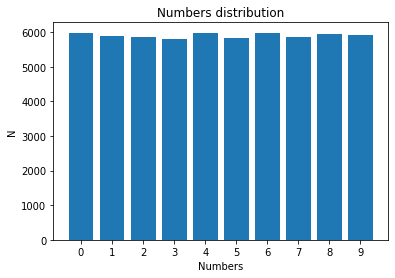

In [19]:
number_dist(df['label'])

# Deep learning

### Data handling

In [20]:
from sklearn.model_selection import train_test_split
from collections import defaultdict

In [21]:
d = defaultdict(lambda:[])

for name in df['img_name'].unique():
    d['img_name'].append(name)
    for j, (_, row) in enumerate(df[df['img_name'] == name].iterrows()):
        d[f'l{j}'].append(str(row['label']))
        
temp_df = pd.DataFrame.from_dict(d)

In [22]:
temp_df.head()

,img_name,l0,l1,l2,l3,l4,l5
0,0.png,1,4,9,9,5,5
1,1.png,7,8,8,2,5,9
2,2.png,7,7,0,4,6,5
3,3.png,7,0,0,0,3,3
4,4.png,4,9,3,8,3,6


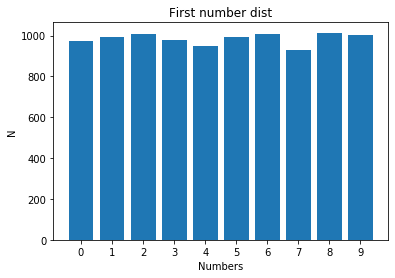

In [23]:
number_dist(temp_df['l0'], 'First number dist')

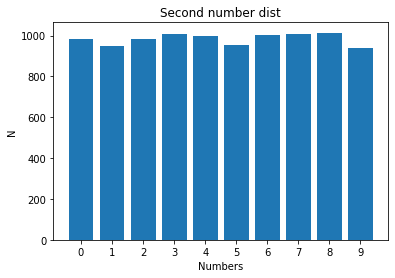

In [24]:
number_dist(temp_df['l1'], 'Second number dist')

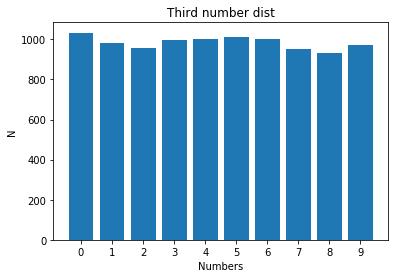

In [25]:
number_dist(temp_df['l2'], 'Third number dist')

I can't split names according to more than two positions (just doesn't work). But as we saw they are almost the same and spliting only by two positions will work

In [26]:
seed = 17
temp_tr, temp_te = train_test_split(temp_df, test_size=0.05, stratify=temp_df[['l0', 'l1']], random_state=seed)
temp_tr, temp_vl = train_test_split(temp_tr, test_size=0.15, stratify=temp_tr[['l0', 'l1']], random_state=seed)

In [27]:
train_df = df[df['img_name'].isin(temp_tr['img_name'])]
val_df = df[df['img_name'].isin(temp_vl['img_name'])]
test_df = df[df['img_name'].isin(temp_te['img_name'])]

This distribution is much more better than random splitting of images

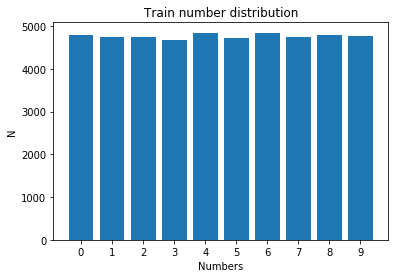

In [28]:
number_dist(train_df['label'], 'Train number distribution')

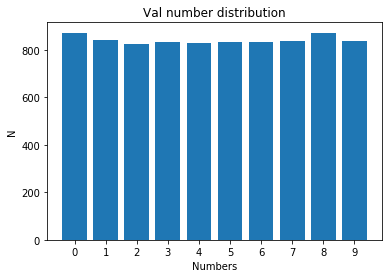

In [29]:
number_dist(val_df['label'], 'Val number distribution')

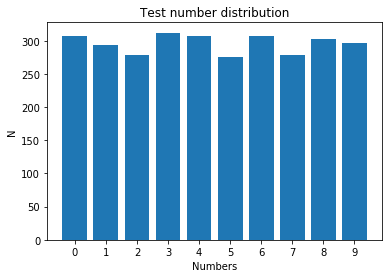

In [30]:
number_dist(test_df['label'], 'Test number distribution')

In [31]:
if not (data_path/'train').is_dir():
    (data_path/'train').mkdir()
if not (data_path/'val').is_dir():
    (data_path/'val').mkdir()
if not (data_path/'test').is_dir():
    (data_path/'test').mkdir()
    
train_images = train_df['img_name'].tolist()
val_images = val_df['img_name'].tolist()
test_images = test_df['img_name'].tolist()

for name in train_images:
    if (data_path/'captchas_labeled'/name).exists():
        copyfile(str(data_path/'captchas_labeled'/name), str(data_path/'train'/name))
    else:
        copyfile(str(data_path/'captchas_unlabeled'/name), str(data_path/'train'/name))
    
for name in val_images:
    if (data_path/'captchas_labeled'/name).exists():
        copyfile(str(data_path/'captchas_labeled'/name), str(data_path/'val'/name))
    else:
        copyfile(str(data_path/'captchas_unlabeled'/name), str(data_path/'val'/name))
    
for name in test_images:
    if (data_path/'captchas_labeled'/name).exists():
        copyfile(str(data_path/'captchas_labeled'/name), str(data_path/'test'/name))
    else:
        copyfile(str(data_path/'captchas_unlabeled'/name), str(data_path/'test'/name)) 

### Data loader

In [32]:
class Vocab():

    def __init__(self, df):
        
        self.vocab = sorted(df['label'].unique())
        self.tok2int = {tok: i + 1 for i, tok in enumerate(self.vocab)}
        self.int2tok = {i: tok for tok, i in self.tok2int.items()}
        
    def __len__(self):
        return len(self.vocab)

In [33]:
class CAPTCHADataset(Dataset):
    
    def __init__(self, data_path, df, vocab, transform_func):
        
        self.df = df
        self.img_names = self.df['img_name'].unique()
        self.vocab = vocab
        self.transform_func = transform_func
        
        imgs = []
        for name in self.img_names:
            imgs.append(plt.imread(str(data_path/name))[:,:,:3])
            
        self.images = np.stack(imgs)
        
    def __len__(self):
        return len(self.img_names)
    
    def __getitem__(self, indx):
        cur_name = self.img_names[indx]
        
        img = self.images[indx]
        boxes, labels = [], []
        
        cur_df = self.df[self.df['img_name'] == cur_name]
        for i, row in cur_df.iterrows():
            boxes.append([row['x0'], row['y0'], row['x1'], row['y1']])
            labels.append(self.vocab.tok2int[row['label']])
        
        if self.transform_func is not None:
            img, boxes, labels = self.transform_func(img, boxes, labels)
        
        img = torch.FloatTensor(img).permute(2,0,1)
        boxes = torch.FloatTensor(boxes) / 300
        labels = torch.LongTensor(labels)
        
        return img, boxes, labels
    
    
def custom_collate(batch):

    images = list()
    boxes = list()
    labels = list()

    for b in batch:
        images.append(b[0])
        boxes.append(b[1])
        labels.append(b[2])

    images = torch.stack(images, dim=0)

    return images, boxes, labels

In [34]:
from transforms.transforms import Compose, BoxesToCoords, ElasticTransform, RandomRotate, \
                                  Expand, CoordsToBoxes, RandomShift, Resize

class SaltPapper(object):
    def __init__(self, pepper=0.01, salt=0.01, prob=0.5, random=np.random):

        self.pepper = pepper
        self.salt = salt
        self.prob = prob
        self.random = random

    def __call__(self, img, cds=None):
        h, w, c = img.shape
        pepper, salt = self.pepper * 100, (1 - self.salt) * 100
        
        if self.random.rand() > self.prob:
            return img, cds

        noise = self.random.randint(100, size = (h, w, 1))
        img = np.where(noise < pepper, 0, img)
        img = np.where(noise > salt, 1, img)
        
        return img, cds

tr = Compose([           
        BoxesToCoords(relative=False),
        Expand((0.7, 1.2), fillval=1),
        ElasticTransform(150, 15, 0.5, fillval=1),
        RandomShift((-0.05, 0.05), fillval=1),
        RandomRotate(10, fillval=1),
        SaltPapper(0.03, 0.07),
        Resize((300, 300)),
        CoordsToBoxes(relative=False),
    ], 
    mode='linear', 
    border='constant', 
    outside_points='clamp')

def transforms(img, boxes, labels):
    
    tr_img, tr_boxes = tr(img, boxes)
    
    # find box indices to remove
    # simple remove if ratio of number is changed considerably more than others
    chng_ratios = []
    for box, tr_box in zip(boxes, tr_boxes):
        x0, y0, x1, y1 = box
        tr_x0, tr_y0, tr_x1, tr_y1 = tr_box
        chng_ratios.append(((x1 - x0) * (y1 - y0)) / ((tr_x1 - tr_x0) * (tr_y1 - tr_y0)))
    med_rat = np.median(chng_ratios)
    ind2remove = np.where((np.array(chng_ratios) - med_rat) > med_rat / 1.3)
    
    tr_boxes = np.delete(tr_boxes, ind2remove, 0)
    tr_labels = np.delete(labels, ind2remove)
    
    return tr_img, tr_boxes, tr_labels 

val_tr = Compose([           
        BoxesToCoords(relative=False),
        Resize((300, 300)),
        CoordsToBoxes(relative=False),
    ], 
    mode='linear', 
    border='constant', 
    outside_points='clamp')

def val_transforms(img, boxes, labels):
    
    tr_img, tr_boxes = val_tr(img, boxes)
    
    return tr_img, tr_boxes, labels 

In [35]:
# vocab = Vocab(train_df)
# vocab.vocab

In [36]:
# train_dataset = CAPTCHADataset(data_path/'train', train_df, vocab, transforms)
# val_dataset = CAPTCHADataset(data_path/'val', val_df, vocab, val_transforms)

In [37]:
# f, ax = plt.subplots(5, 4, figsize=(20, 15))

# for i in range(20):
#     img, boxes, labels = train_dataset[i]
    
#     img = img.squeeze().permute(1,2,0).numpy()
#     boxes = boxes.numpy()
#     labels = labels.numpy()
    
#     r, c = i // 4, i % 4
#     ax[r][c].imshow(img, cmap='gray')
    
#     for (x0, y0, x1, y1), lbl in zip(boxes, labels):
#         x0, y0, x1, y1 = x0 * 300, y0 * 300, x1 * 300, y1 * 300
#         w, h = x1 - x0, y1 - y0
#         rect = patches.Rectangle((x0, y0), w, h, linewidth=1, edgecolor='r', facecolor='none')
#         ax[r][c].add_patch(rect)
#         ax[r][c].text(x0, y0, vocab.int2tok[lbl], fontsize=16)
#         ax[r][c].axis('off')
# plt.show()

# Training

In [40]:
def train(model, loader, criterion, optimizer, epoch=None, lr_scheduler=None, fp16=False):
    model.train()
    
    if epoch: tqdm_text = f'Training {epoch} epoch'
    else:  tqdm_text = f'Training'
        
    epoch_loss = 0.
    for imgs, boxes, labels in tqdm(loader, desc=tqdm_text):
        imgs = imgs.cuda()
        boxes = [i.cuda() for i in boxes]
        labels = [i.cuda() for i in labels]
        
        pred_boxes, pred_scores = model(imgs)
        
        loss = criterion(pred_boxes, pred_scores, boxes, labels)
        
        optimizer.zero_grad()
        if fp16:
            with amp.scale_loss(loss, optimizer) as scaled_loss:
                scaled_loss.backward()
        else:
            loss.backward()
        optimizer.step()
        
        if lr_scheduler:
            lr_scheduler.step()
            
        epoch_loss += loss.item()
        
    return epoch_loss / len(loader)


def evaluate(model, loader, criterion, epoch=None):
    model.eval()
    
    if epoch: tqdm_text = f'Evaluating {epoch} epoch'
    else:  tqdm_text = f'Evaluating'
    
    epoch_loss = 0.
    with torch.no_grad():
        for imgs, boxes, labels in tqdm(loader, desc=tqdm_text):
            imgs = imgs.cuda()
            boxes = [i.cuda() for i in boxes]
            labels = [i.cuda() for i in labels]

            pred_boxes, pred_scores = model(imgs)

            loss = criterion(pred_boxes, pred_scores, boxes, labels)

            epoch_loss += loss.item()
        
    return epoch_loss / len(loader)


class History():
    
    def __init__(self):
        
        self.train_losses = []
        self.val_losses = []
        
    def update(self, train_loss, val_loss):
        self.train_losses.append(train_loss)
        self.val_losses.append(val_loss)
        

In [41]:
def patrially_load_state_dict(model, state_dict):
    """
    copies params which can be loaded from given sate dict in place
    returns: dict {layer_name: whether it was changed}
    """
    were_loaded = {}
    own_state = model.state_dict()
    for name, param in state_dict.items():
        param = param.data
        if name not in own_state:
            were_loaded[name] = False
            continue
        if own_state[name].shape != param.shape:
            were_loaded[name] = False
            continue
        own_state[name].copy_(param)
        were_loaded[name] = True
    return were_loaded

In [42]:
config = dict(
    epochs = 150,
    bs = 28,
    wait = 5,
)

vocab = Vocab(train_df)

train_dataset = CAPTCHADataset(data_path/'train', train_df, vocab, transforms)
val_dataset = CAPTCHADataset(data_path/'val', val_df, vocab, val_transforms)

train_loader = DataLoader(train_dataset, config['bs'], collate_fn=custom_collate, num_workers=8)
val_loader = DataLoader(val_dataset, config['bs'], collate_fn=custom_collate, num_workers=8)

history = History()

In [41]:
ssd_model = SSD300(len(vocab) + 1)
ssd_model.cuda()

checkpointed_state_dict = torch.load('../models/BEST_checkpoint_ssd300.pth')['model'].state_dict()

was_loaded_dict = patrially_load_state_dict(ssd_model, checkpointed_state_dict)


Loaded base model.



/home/egor/venvs/captcha_recognition/lib/python3.6/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'model.SSD300' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/egor/venvs/captcha_recognition/lib/python3.6/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'model.VGGBase' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/egor/venvs/captcha_recognition/lib/python3.6/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the

In [42]:
param_groups = [
    {'params': [w for name, w in ssd_model.base.named_parameters() if re.findall('[a-z]1', name)]},
    {'params': [w for name, w in ssd_model.base.named_parameters() if re.findall('[a-z]2', name)]},
    {'params': [w for name, w in ssd_model.base.named_parameters() if re.findall('[a-z]3', name)]},
    {'params': [w for name, w in ssd_model.base.named_parameters() if re.findall('[a-z]4', name)]},
    {'params': [w for name, w in ssd_model.base.named_parameters() if re.findall('[a-z]5', name)]},
    {'params': [w for name, w in ssd_model.base.named_parameters() if re.findall('[a-z][67]', name)]},
    {'params': ssd_model.aux_convs.parameters()},
    {'params': ssd_model.pred_convs.parameters()}
]

optimizer = torch.optim.RAdam(param_groups, lr=1e-3, weight_decay=1e-3)
criterion = MultiBoxLoss(ssd_model.priors_cxcy)

/home/egor/venvs/captcha_recognition/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [43]:
ssd_model, optimizer = amp.initialize(ssd_model, optimizer, opt_level="O1", verbosity=0)

In [51]:
for name, param in ssd_model.named_parameters():
    if was_loaded_dict[name] is True:
        param.requires_grad = False
    else:
        param.requires_grad = True

In [52]:
best_loss = np.inf
for epoch in range(2):
    
    train_loss = train(ssd_model, train_loader, criterion, optimizer, epoch=epoch+1, fp16=True)
    val_loss = evaluate(ssd_model, val_loader, criterion, epoch=epoch+1)
    
    print('{}: train loss {:.4f}, val loss {:.4f}'.format(epoch+1, train_loss, val_loss))

Training 2 epoch:   0%|          | 0/249 [00:00<?, ?it/s]

1: train loss 6.6512, val loss 5.4110


Evaluating 2 epoch: 100%|██████████| 44/44 [00:15<00:00,  3.04it/s]

2: train loss 5.1195, val loss 5.2627


In [68]:
torch.save({'model_state_dict': ssd_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
        }, '../models/fns_ssd_head_huge_data.ptr', )

In [70]:
ssd_model.load_state_dict(torch.load('../models/fns_ssd_head_huge_data.ptr', 
                                     map_location='cpu')['model_state_dict'])
optimizer.load_state_dict(torch.load('../models/fns_ssd_head_huge_data.ptr',
                                     map_location='cpu')['optimizer_state_dict'])

In [71]:
for param in ssd_model.parameters():
    param.requires_grad = True

In [72]:
base_lr = 1e-3

def lr_update(n, base_lr):
    # epochs are counted from 0
    return base_lr * 0.7 ** n

for i, group in enumerate(optimizer.param_groups[::-1]):
    cur_lr = lr_update(i, base_lr)
    group['lr'] = cur_lr

In [73]:
for group in optimizer.param_groups:
    print(group['lr'])

8.235429999999997e-05
0.00011764899999999997
0.00016806999999999995
0.00024009999999999995
0.00034299999999999993
0.00049
0.0007
0.001


In [74]:
best_loss = np.inf
no_improvement = 0
early_stop_cntr = 0
for epoch in range(config['epochs']):
    
    train_loss = train(ssd_model, train_loader, criterion, optimizer, epoch=epoch+1, fp16=True)
    val_loss = evaluate(ssd_model, val_loader, criterion, epoch=epoch+1)
    
    if val_loss < best_loss:
        best_loss = val_loss
        no_improvement = 0
        early_stop_cntr = 0
        torch.save({
            'model_state_dict': ssd_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
        }, '../models/fns_ssd_huge_data.ptr')
    
    else:
        if no_improvement > 7:
            print('Lr decreased by 0.5')
            for group in optimizer.param_groups:
                group['lr'] = group['lr'] * 0.5
            no_improvement = 0
        elif early_stop_cntr > 25:
            print('Early stopped')
            print('{}: train loss {:.4f}, val loss {:.4f}'.format(epoch+1, train_loss, val_loss))
            break
        else:
            no_improvement += 1
            early_stop_cntr += 1
            
    history.update(train_loss, val_loss)
    print('{}: train loss {:.4f}, val loss {:.4f}'.format(epoch+1, train_loss, val_loss))

Training 2 epoch:   0%|          | 0/284 [00:00<?, ?it/s]

1: train loss 3.1405, val loss 2.0494


Training 3 epoch:   0%|          | 0/284 [00:00<?, ?it/s]

2: train loss 1.9340, val loss 1.5400


Training 4 epoch:   0%|          | 0/284 [00:00<?, ?it/s]

3: train loss 1.6117, val loss 1.3713


Training 5 epoch:   0%|          | 0/284 [00:00<?, ?it/s]

4: train loss 1.4274, val loss 1.3440


Training 6 epoch:   0%|          | 0/284 [00:00<?, ?it/s]

5: train loss 1.3068, val loss 1.2992


Training 7 epoch:   0%|          | 0/284 [00:00<?, ?it/s]

6: train loss 1.2153, val loss 1.3267


Training 7 epoch:   2%|▏         | 5/284 [00:07<07:22,  1.59s/it]


KeyboardInterrupt: 

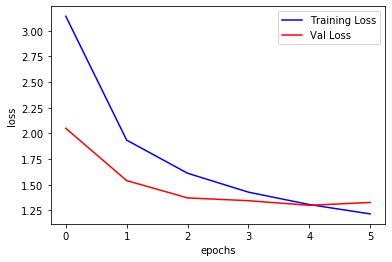

In [75]:
epochs = list(range(len(history.train_losses)))
plt.plot(epochs, history.train_losses, 'b')
plt.plot(epochs, history.val_losses, 'r')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['Training Loss', 'Val Loss'])
plt.show();

In [44]:
ssd_model.load_state_dict(torch.load('../models/fns_ssd_huge_data.ptr')['model_state_dict'])
optimizer.load_state_dict(torch.load('../models/fns_ssd_huge_data.ptr')['optimizer_state_dict'])

In [45]:
base_lr = 1e-4

def lr_update(n, base_lr):
    # epochs are counted from 0
    return base_lr * 0.7 ** n

for i, group in enumerate(optimizer.param_groups[::-1]):
    cur_lr = lr_update(i, base_lr)
    group['lr'] = cur_lr

In [46]:
best_loss = 1.2992
no_improvement = 0
early_stop_cntr = 0
for epoch in range(10):
    
    train_loss = train(ssd_model, train_loader, criterion, optimizer, epoch=epoch+1, fp16=True)
    val_loss = evaluate(ssd_model, val_loader, criterion, epoch=epoch+1)
    
    if val_loss < best_loss:
        best_loss = val_loss
        no_improvement = 0
        early_stop_cntr = 0
        torch.save({
            'model_state_dict': ssd_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
        }, '../models/fns_ssd_huge_data_1.ptr')
    
    history.update(train_loss, val_loss)
    print('{}: train loss {:.4f}, val loss {:.4f}'.format(epoch+1, train_loss, val_loss))

Training 2 epoch:   0%|          | 0/284 [00:00<?, ?it/s]

1: train loss 1.4621, val loss 1.1571


Training 3 epoch:   0%|          | 0/284 [00:00<?, ?it/s]

2: train loss 1.3794, val loss 1.1345


Training 4 epoch:   0%|          | 0/284 [00:00<?, ?it/s]

3: train loss 1.3283, val loss 1.1185


Training 5 epoch:   0%|          | 0/284 [00:00<?, ?it/s]

4: train loss 1.2830, val loss 1.1190


Training 6 epoch:   0%|          | 0/284 [00:00<?, ?it/s]

5: train loss 1.2399, val loss 1.1322


Training 7 epoch:   0%|          | 0/284 [00:00<?, ?it/s]

6: train loss 1.1983, val loss 1.1564


Training 8 epoch:   0%|          | 0/284 [00:00<?, ?it/s]

7: train loss 1.1575, val loss 1.1804


Training 8 epoch:   1%|▏         | 4/284 [00:06<07:40,  1.64s/it]Process Process-117:
Process Process-114:
Process Process-115:
Process Process-116:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 261, in _bootstrap
    util._exit_function()
  File "/usr/lib/python3.6/multiprocessing/util.py", line 322, in _exit_function
    _run_finalizers()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 261, in _bootstrap
    util._exit_function()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 261, in _bootstrap
    util._exit_function()
  File "/usr/lib/python3.6/multiprocessing/util.py", line 262, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.6/multiprocessing/util.py", line 322, in _exit_function
    _run_finalizers()
  File "/usr/lib/python3.6/multiprocessing/util.py", line 322, in _exit_function
    _run

KeyboardInterrupt: 

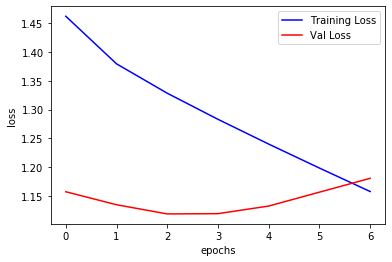

In [47]:
epochs = list(range(len(history.train_losses)))
plt.plot(epochs, history.train_losses, 'b')
plt.plot(epochs, history.val_losses, 'r')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['Training Loss', 'Val Loss'])
plt.show();

In [44]:
ssd_model.load_state_dict(torch.load('../models/fns_ssd_huge_data_1.ptr')['model_state_dict'])
optimizer.load_state_dict(torch.load('../models/fns_ssd_huge_data_1.ptr')['optimizer_state_dict'])

In [45]:
base_lr = 1e-5

def lr_update(n, base_lr):
    # epochs are counted from 0
    return base_lr * 1 ** n

for i, group in enumerate(optimizer.param_groups[::-1]):
    cur_lr = lr_update(i, base_lr)
    group['lr'] = cur_lr

In [46]:
best_loss = 1.1185
no_improvement = 0
early_stop_cntr = 0
for epoch in range(10):
    
    train_loss = train(ssd_model, train_loader, criterion, optimizer, epoch=epoch+1, fp16=True)
    val_loss = evaluate(ssd_model, val_loader, criterion, epoch=epoch+1)
    
    if val_loss < best_loss:
        best_loss = val_loss
        no_improvement = 0
        early_stop_cntr = 0
        torch.save({
            'model_state_dict': ssd_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
        }, '../models/fns_ssd_huge_data_2.ptr')
    
    history.update(train_loss, val_loss)
    print('{}: train loss {:.4f}, val loss {:.4f}'.format(epoch+1, train_loss, val_loss))

Training 2 epoch:   0%|          | 0/284 [00:00<?, ?it/s]

1: train loss 1.3633, val loss 1.0756


Training 3 epoch:   0%|          | 0/284 [00:00<?, ?it/s]

2: train loss 1.3020, val loss 1.0658


Training 4 epoch:   0%|          | 0/284 [00:00<?, ?it/s]

3: train loss 1.2528, val loss 1.0694


Training 5 epoch:   0%|          | 0/284 [00:00<?, ?it/s]

4: train loss 1.2075, val loss 1.0857


Training 6 epoch:   0%|          | 0/284 [00:00<?, ?it/s]

5: train loss 1.1640, val loss 1.1038


Training 7 epoch:   0%|          | 0/284 [00:00<?, ?it/s]

6: train loss 1.1212, val loss 1.1278


Training 8 epoch:   0%|          | 0/284 [00:00<?, ?it/s]

7: train loss 1.0786, val loss 1.1540


Training 9 epoch:   0%|          | 0/284 [00:00<?, ?it/s]

8: train loss 1.0361, val loss 1.1887


Training 10 epoch:   0%|          | 0/284 [00:00<?, ?it/s]

9: train loss 0.9935, val loss 1.2192


Evaluating 10 epoch: 100%|██████████| 51/51 [00:15<00:00,  3.20it/s]

10: train loss 0.9510, val loss 1.2534


In [55]:
ssd_model.load_state_dict(torch.load('../models/fns_ssd_huge_data_1.ptr')['model_state_dict'])
optimizer.load_state_dict(torch.load('../models/fns_ssd_huge_data_1.ptr')['optimizer_state_dict'])

In [56]:
base_lr = 1e-5

def lr_update(n, base_lr):
    # epochs are counted from 0
    return base_lr * 1 ** n

for i, group in enumerate(optimizer.param_groups[::-1]):
    cur_lr = lr_update(i, base_lr)
    group['lr'] = cur_lr

In [48]:
best_loss = 1.9409
no_improvement = 0
early_stop_cntr = 0
for epoch in range(10):
    
    train_loss = train(ssd_model, train_loader, criterion, optimizer, epoch=epoch+1, fp16=True)
    val_loss = evaluate(ssd_model, val_loader, criterion, epoch=epoch+1)
    
    if val_loss < best_loss:
        best_loss = val_loss
        no_improvement = 0
        early_stop_cntr = 0
        torch.save({
            'model_state_dict': ssd_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
        }, '../models/fns_ssd_0_3.ptr')
    
    history.update(train_loss, val_loss)
    print('{}: train loss {:.4f}, val loss {:.4f}'.format(epoch+1, train_loss, val_loss))

Training 2 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

1: train loss 1.7306, val loss 1.9621


Training 3 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

2: train loss 1.7256, val loss 1.9589


Training 4 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

3: train loss 1.7161, val loss 1.9591


Training 5 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

4: train loss 1.7063, val loss 1.9589


Training 6 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

5: train loss 1.6972, val loss 1.9589


Training 7 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

6: train loss 1.6883, val loss 1.9590


Training 8 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

7: train loss 1.6794, val loss 1.9590


Training 9 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

8: train loss 1.6705, val loss 1.9592


Training 10 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

9: train loss 1.6617, val loss 1.9594


Training 10 epoch:   6%|▋         | 2/32 [00:03<01:00,  2.01s/it]Process Process-306:
Process Process-311:
Process Process-305:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 261, in _bootstrap
    util._exit_function()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 261, in _bootstrap
    util._exit_function()
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/util.py", line 322, in _exit_function
    _run_finalizers()
  File "/usr/lib/python3.6/multiprocessing/util.py", line 322, in _exit_function
    _run_finalizers()
  File "/usr/lib/python3.6/multiprocessing/util.py", line 262, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 261, in _bootstrap
    util._exit_function()
  File "/usr/lib/python3.6/multiprocessing/util.py", line 262, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.6/multiprocessing/util

KeyboardInterrupt: 

In [166]:
ssd_model = SSD300(len(vocab) + 1)
ssd_model.cuda();


Loaded base model.



In [204]:
ssd_model.load_state_dict(torch.load('../models/fns_ssd_huge_data_2.ptr')['model_state_dict'])
ssd_model.eval();

In [205]:
from utils import *
from PIL import Image, ImageDraw, ImageFont
import torchvision.transforms as T

resize = T.Resize((300, 300))
to_tensor = T.ToTensor()

def detect(model, original_image, indx2lbl, min_score, max_overlap, top_k, suppress=None):
    """
    Detect objects in an image with a trained SSD300, and visualize the results.

    :param original_image: image, a PIL Image
    :param min_score: minimum threshold for a detected box to be considered a match for a certain class
    :param max_overlap: maximum overlap two boxes can have so that the one with the lower score is not suppressed via Non-Maximum Suppression (NMS)
    :param top_k: if there are a lot of resulting detection across all classes, keep only the top 'k'
    :param suppress: classes that you know for sure cannot be in the image or you do not want in the image, a list
    :return: annotated image, a PIL Image
    """

    image = to_tensor(resize(original_image)).cuda()
    image = image[:3, :, :]

    predicted_locs, predicted_scores = model(image.unsqueeze(0))

    det_boxes, det_labels, det_scores = model.detect_objects(predicted_locs, predicted_scores, min_score=min_score,
                                                             max_overlap=max_overlap, top_k=top_k)
    
    det_boxes = det_boxes[0].detach().cpu().numpy()

    # Transform to original image dimensions
    original_dims = np.array([original_image.width, original_image.height, original_image.width, original_image.height])
    det_boxes = det_boxes * original_dims
    
    det_labels = [indx2lbl[l] for l in det_labels[0].detach().cpu().tolist() if l != 0.]

    # If no objects found, the detected labels will be set to ['0.'], i.e. ['background'] in SSD300.detect_objects() in model.py
    if det_labels == ['background']:
        # Just return original image
        return original_image

    return original_image, det_boxes, det_labels

In [206]:
from time import time
times = []

IndexError: index 24 is out of bounds for axis 0 with size 24

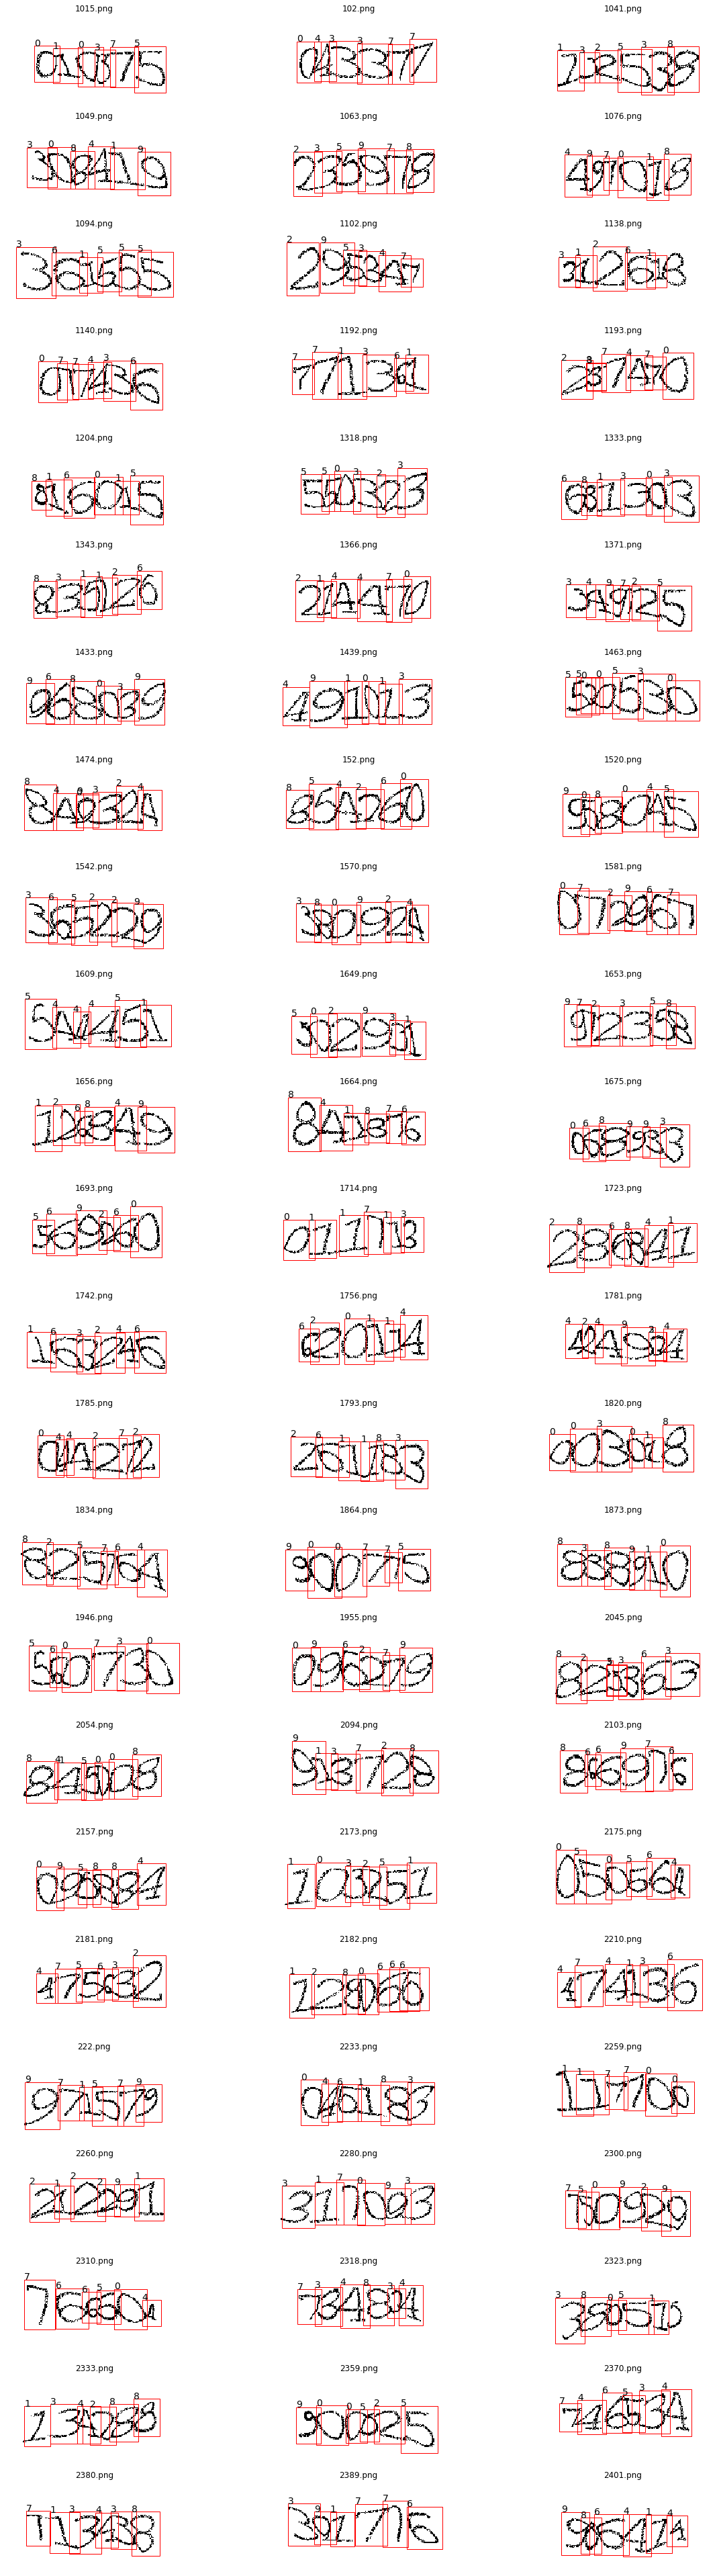

In [199]:
import matplotlib.patches as patches
from os.path import join

cntr = 0
threshold = 0.5

# Create figure and axes
fig,ax = plt.subplots(24, 3, figsize=(20, 70))

path = str(data_path/'test')
for name in sorted(listdir(path)):
    if 'png' not in name:
        continue
    full_name = join(path, name)
    t0 = time()
    im = Image.open(full_name)
    img, pred_boxes, det_labels = detect(ssd_model, im, vocab.int2tok, 
                                         min_score=threshold, max_overlap=0.5, top_k=200)
    times.append(time() - t0)
    
    row, col = cntr // 3, cntr % 3
    # Display the image
    ax[row, col].imshow(im)

    # Create a Rectangle patch
    for (x0, y0, x1, y1), label in zip(pred_boxes, det_labels):
        w, h = x1 - x0, y1 - y0
        rect = patches.Rectangle((x0,y0),w,h,linewidth=1, edgecolor='r',facecolor='none')
        ax[row, col].text(x0, y0, f'{label}', fontsize=14)
        ax[row, col].add_patch(rect)
        ax[row, col].set_title(name)
    
    ax[row, col].axis('off')
    cntr += 1
plt.show()
fig.savefig(str(base_path/'performance/ssd_1.jpg'))

### Evaluation

In [183]:
from time import time
from collections import defaultdict
from tqdm import tqdm
times = []

res_d = defaultdict(lambda: [])

for path in tqdm((data_path/'test').iterdir(), total=len(list((data_path/'test').iterdir()))):
    name = path.name
    
    t0 = time()
    
    im = Image.open(path)
    img, pred_boxes, det_labels = detect(ssd_model, im, vocab.int2tok, 
                                         min_score=0.5, max_overlap=0.5, top_k=200)
    pred_boxes = pred_boxes[:6,:]
    det_labels = det_labels[:6]

    inds = np.argsort([i[0] for i in pred_boxes])
    pred = np.array(det_labels)[inds]
    pred = ''.join(pred)
    
    times.append(time() - t0)
    
    true = test_df[test_df['img_name'] == name]['label'].tolist()
    true = ''.join(true)
    
    res_d['name'].append(name)
    res_d['y_pred'].append(pred)
    res_d['y_true'].append(true)
    
res_df = pd.DataFrame.from_dict(res_d)

100%|██████████| 493/493 [00:10<00:00, 46.23it/s]


In [184]:
np.mean(times), np.median(times)

(0.0207659888702764, 0.020721912384033203)

In [185]:
right, wrong = (res_df['y_pred'] == res_df['y_true']).value_counts()

In [186]:
precision = right / (right + wrong)

In [187]:
precision

0.8600405679513184